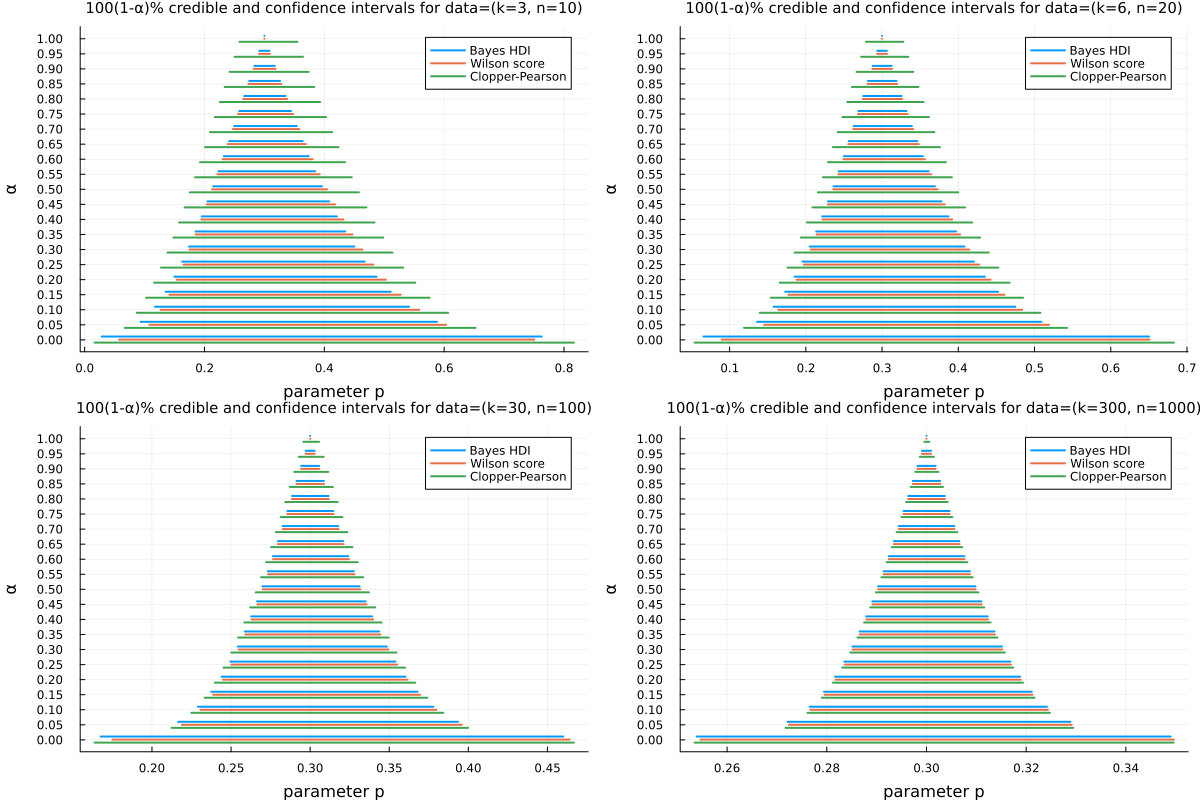

In [1]:
using Distributions
using Optim: optimize, Brent
using StatsPlots
default(fmt=:png, titlefontsize=10)

function confint_score(k_new, n_new, α=0.05; prior_data=(k_prior=0, n_prior=0))
    (; k_prior, n_prior) = prior_data
    k, n = k_prior + k_new, n_prior + n_new
    p̂ = k/n
    z = quantile(Normal(), 1-α/2)
    a, b, c = 1+z^2/n, p̂+z^2/(2n), p̂^2
    # ap² - 2bp + c = 0 を解く.
    sqrtD = √(b^2 - a*c)
    p_L = (b - sqrtD)/a
    p_U = (b + sqrtD)/a
    [p_L, p_U]
end

function confint_clopper_pearson(k_new, n_new, α=0.05; prior_data=(k_prior=0, n_prior=0))
    (; k_prior, n_prior) = prior_data
    k, n = k_prior + k_new, n_prior + n_new
    p_L = quantile(Beta(k, n-k+1), α/2)
    p_U = cquantile(Beta(k+1, n-k), α/2)
    [p_L, p_U]
end

function highest_density_interval(dist, α=0.05)
    f(p) = quantile(dist, min(1, p+(1-α))) - quantile(dist, p)
    o = optimize(f, 0, α, Brent())
    p = o.minimizer
    [quantile(dist, p), quantile(dist, min(1, p+(1-α)))]
end

function credint_hdi(k, n, α=0.05; prior=Beta(1, 1))
    κ, λ = params(prior)
    posterior = Beta(κ+k, λ+n-k)
    m = mode(posterior)
    α ≈ 1 && return [m, m]
    highest_density_interval(posterior, α)
end

function plot_intervals(; k=6, n=20)
    plot()
    l = true
    for α in [0.001; 0.05:0.05:1]
        plot!(credint_hdi(k, n, α), fill(α+0.01, 2); label=(l ? "Bayes HDI" : ""), c=1, lw=2)
        plot!(confint_score(k, n, α), fill(α, 2); label=(l ? "Wilson score" : ""), c=2, lw=2)
        plot!(confint_clopper_pearson(k, n, α), fill(α-0.01, 2); label=(l ? "Clopper-Pearson" : ""), c=3, lw=2)
        l = false
    end
    plot!(ytick=0:0.05:1)
    plot!(xguide="parameter p", yguide="α")
    title!("100(1-α)% credible and confidence intervals for data=(k=$k, n=$n)")
end

PP = []
for (k, n) in ((3, 10), (6, 20), (30, 100), (300, 1000))
    P = plot_intervals(; k, n)
    push!(PP, P)
end
plot!(PP...; size=(1200, 800), layout=(2, 2))
plot!(leftmargin=4Plots.mm)